<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp; from scipy.io import wavfile; from scipy import signal
from scipy.signal import windows, freqz
import pydub
from pydub import AudioSegment

The sampling rate of the audio files.

In [3]:
sr = 44100

Little function used to write to audio files.

In [4]:
def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

# Get Data

In [5]:
df_a = pd.read_pickle("./acoustic_df.pkl")

In [6]:
E = np.array(df_a['E'].dropna()); Em = np.array(df_a['E_mute'].dropna()); 
A = np.array(df_a['A'].dropna()); Am = np.array(df_a['A_mute'].dropna()); 
D = np.array(df_a['D'].dropna()); Dm = np.array(df_a['D_mute'].dropna()); 
G = np.array(df_a['G'].dropna()); Gm = np.array(df_a['G_mute'].dropna()); 
B = np.array(df_a['B'].dropna()); Bm = np.array(df_a['B_mute'].dropna()); 
Eh = np.array(df_a['Eh'].dropna()); Ehm = np.array(df_a['Eh_mute'].dropna()); 

# Filtering

Apply a few filters to the time series of the form

$$L[X_t] = \sum_{u=-\infty}^\infty g_u X_{t-u} $$

In [7]:
def remove_mean(arr):
    return np.mean(arr), arr-np.mean(arr)

In [8]:
def apply_filt(arr, g):
    
    new_arr = np.empty(shape=len(arr))
    seq_len = len(g)
    
    for (i, a_i) in enumerate(arr):
        for(j, g_j) in enumerate(g):
            if i-j<0:
                break
            new_arr[i] += g_j*arr[i-j]
    return new_arr

In [9]:
def apply_filt_fast(arr, g):
    return np.convolve(g, arr)[0:len(arr)]

# See Question 5.7a
def apply_filt_fast_highpass(arr, g):
    a = np.empty((len(arr),)); a[::2] = 1; a[1::2] = -1
    arr_flipped = arr*a
    arr_flipped_filt = np.convolve(g, arr_flipped)[0:len(arr)]
    return a*arr_flipped_filt

In [10]:
E_mean, E_d = remove_mean(E)
write('modified_sounds/ac_E_demean.mp3', sr, E_d, normalized=False)

## Autoregressive Filter

### Define Transfer Function

Define the autoregressive transfer function

In [11]:
g_auto1 = np.array([np.e**(-(t/50)) for t in range(100)])
g_auto1 = g_auto1/np.sum(g_auto1)

g_auto2 = np.array([np.e**(-(t/200)) for t in range(200)])
g_auto2 = g_auto2/np.sum(g_auto2)

### Plot Transfer Function

Plot the transfer functions

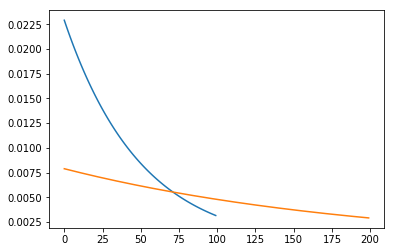

In [12]:
plt.plot(g_auto1)
plt.plot(g_auto2)

### Apply the Filter

In [13]:
E_autoreg1 = apply_filt_fast(E, g_auto1)
E_autoreg2 = apply_filt_fast(E, g_auto2)
write('modified_sounds/ac_E_autoreg1.mp3', sr, E_autoreg1, normalized=False)
write('modified_sounds/ac_E_autoreg2.mp3', sr, E_autoreg2, normalized=False)

### Plot Filtered Signal

(0, 2000)

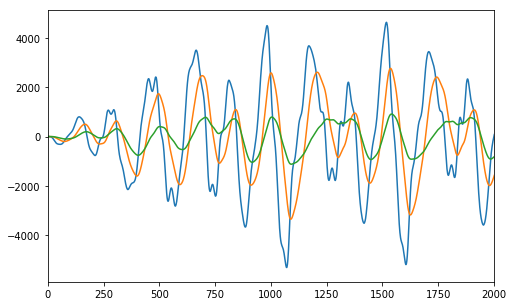

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(E_d)
ax.plot(E_autoreg1)
ax.plot(E_autoreg2)

ax.set_xlim(0,2000)

### Compute periodogram

In [15]:
f_E, Pxx_den_E_d = signal.periodogram(E_d, sr)
f_E_autoreg1, Pxx_den_E_autoreg1 = signal.periodogram(E_autoreg1, sr)
f_E_autoreg2, Pxx_den_E_autoreg2 = signal.periodogram(E_autoreg2, sr)

### Plot periodogram

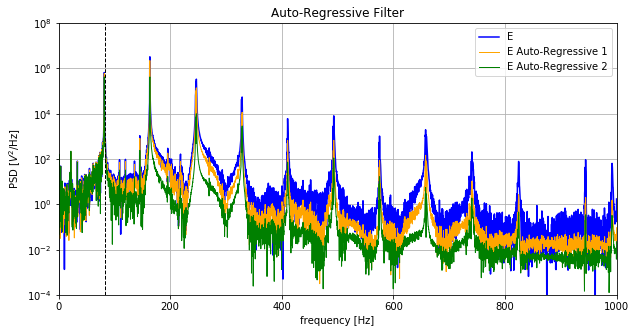

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.semilogy(f_E, Pxx_den_E_d, label='E', c='blue')
ax.semilogy(f_E_autoreg1, Pxx_den_E_autoreg1, label='E Auto-Regressive 1', lw=1, c='Orange')
ax.semilogy(f_E_autoreg2, Pxx_den_E_autoreg2, label='E Auto-Regressive 2', lw=1, c='Green')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [$V^2$/Hz]')
ax.set_xlim(0,1000)
ax.set_ylim(10**-4, 10**8)
ax.legend()
ax.grid()
ax.set_title('Auto-Regressive Filter')

# Main Frequencies of a Guitar in Tune
ax.axvline(82.4, ls='--', color='k', lw=1)

plt.savefig('test_plot.png', dpi=300)
plt.show()

Conclusion: The exponentialally decreasing auto-regressive filter is effective for slightly removing power at higher Fourier nodes.

## Least Squares Filter

All filters below will use this value of $K$ (sets number of points able to be used)

In [17]:
K = 1000

### Define the Transfer Function

Define the least squares function (see pg 176-177)

In [18]:
def g_UI(u, W):
    if u==0:
        return 2*W
    else:
        return np.sin(2*np.pi*W*u)/(np.pi*u)

Define various cutoff frequencies.

In [19]:
f1 = 200
f2 = 100
f3 = 510

### Compute the Sequences and Transfer Functions

In [20]:
W=f1/sr
g_lsq1 = np.array([g_UI(i, W) for i in range(-int(np.floor(K/2)), int(np.floor(K/2)))])
f_lsq1, G_lsq1 = freqz(g_lsq1, worN=K)

W=f2/sr
g_lsq2 = np.array([g_UI(i, W) for i in range(-int(np.floor(K/2)), int(np.floor(K/2)))])
f_lsq2, G_lsq2 = freqz(g_lsq2, worN=K)

W=f3/sr
g_lsq3 = np.array([g_UI(i, W) for i in range(-int(np.floor(K/2)), int(np.floor(K/2)))])
f_lsq3, G_lsq3 = freqz(g_lsq3, worN=K)

### Apply filers to the Signal

Apply lowpass filter

In [21]:
E_lsq1 = apply_filt_fast(E, g_lsq1)
E_lsq2 = apply_filt_fast(E, g_lsq2)
E_lsq3 = apply_filt_fast(E, g_lsq3)
write('modified_sounds/ac_E_lsq1.mp3', sr, E_lsq1, normalized=False)
write('modified_sounds/ac_E_lsq2.mp3', sr, E_lsq2, normalized=False)
write('modified_sounds/ac_E_lsq3.mp3', sr, E_lsq3, normalized=False)

Apply highpass filter

In [22]:
E_lsq1_h = apply_filt_fast_highpass(E, g_lsq1)
E_lsq3_h = apply_filt_fast_highpass(E, g_lsq3)

### Compute and Plot Periodogram

Compute periodogram for low pass

In [23]:
f_E_lsq1, Pxx_den_E_lsq1 = signal.periodogram(E_lsq1, sr)
f_E_lsq2, Pxx_den_E_lsq2 = signal.periodogram(E_lsq2, sr)
f_E_lsq3, Pxx_den_E_lsq3 = signal.periodogram(E_lsq3, sr)

For high pass

In [24]:
f_E_lsq1_h, Pxx_den_E_lsq1_h = signal.periodogram(E_lsq1_h, sr)
f_E_lsq3_h, Pxx_den_E_lsq3_h = signal.periodogram(E_lsq3_h, sr)

Plot

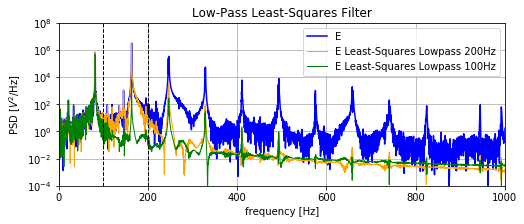

In [25]:
fig, ax = plt.subplots(1,1, figsize=(8,3))

ax.semilogy(f_E, Pxx_den_E_d, label='E', c='blue')
ax.semilogy(f_E_lsq1, Pxx_den_E_lsq1, label='E Least-Squares Lowpass 200Hz', lw=1, c='Orange')
ax.semilogy(f_E_lsq2, Pxx_den_E_lsq2, label='E Least-Squares Lowpass 100Hz', lw=1, c='Green')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [$V^2$/Hz]')
ax.set_xlim(0,1000)
ax.set_ylim(10**-4, 10**8)
ax.legend()
ax.grid()
ax.set_title('Low-Pass Least-Squares Filter')

# Main Frequencies of a Guitar in Tune
ax.axvline(100, ls='--', color='k', lw=1)
ax.axvline(200, ls='--', color='k', lw=1)

plt.savefig('test_plot.png', dpi=300)
plt.show()

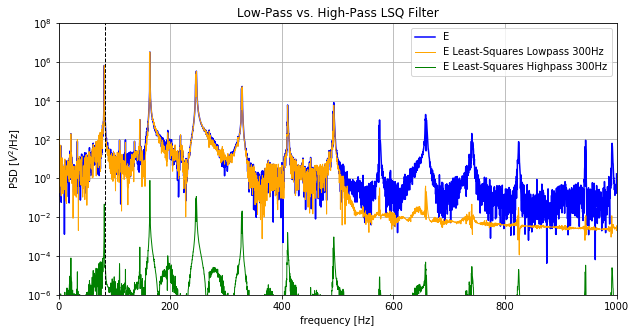

In [26]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.semilogy(f_E, Pxx_den_E_d, label='E', c='blue')
ax.semilogy(f_E_lsq3, Pxx_den_E_lsq3, label='E Least-Squares Lowpass 300Hz', lw=1, c='Orange')
ax.semilogy(f_E_lsq3_h, Pxx_den_E_lsq3_h, label='E Least-Squares Highpass 300Hz', lw=1, c='Green')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [$V^2$/Hz]')
ax.set_xlim(0,1000)
ax.set_ylim(10**-6, 10**8)
ax.legend()
ax.grid()
ax.set_title('Low-Pass vs. High-Pass LSQ Filter')

# Main Frequencies of a Guitar in Tune
ax.axvline(82.4, ls='--', color='k', lw=1)

plt.savefig('test_plot.png', dpi=300)
plt.show()

## DPSS Filter

Modify the least squares transfer function to reduce side-lobes (see 181-183).

In [27]:
delta = 0.97
g_dpss1 = windows.dpss(K, delta) * g_lsq1
f_dpss1, G_dpss1 = freqz(g_dpss1, worN=K)

delta = 0.97
g_dpss2 = windows.dpss(K, delta) * g_lsq2
f_dpss2, G_dpss2 = freqz(g_dpss2)

delta = 0.8
g_dpss3 = windows.dpss(K, delta) * g_lsq3
f_dpss3, G_dpss3 = freqz(g_dpss3, worN=K)

### Compare DPSS to LSQ Sequence and Response Function

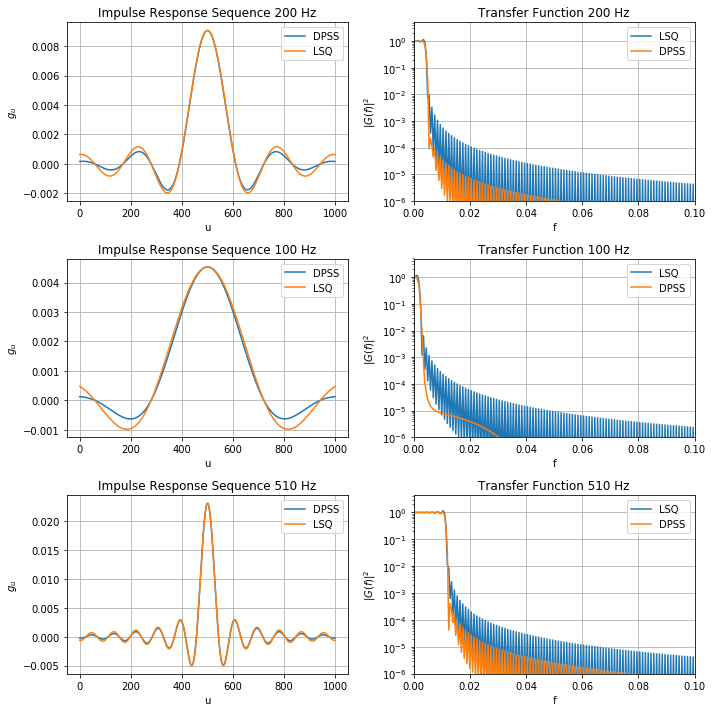

In [28]:
fig, ax = plt.subplots(3,2,figsize=(10,10))

ax[0,0].plot(g_dpss1, label='DPSS')
ax[0,0].plot(g_lsq1, label='LSQ')
ax[1,0].plot(g_dpss2, label='DPSS')
ax[1,0].plot(g_lsq2, label='LSQ')
ax[2,0].plot(g_dpss3, label='DPSS')
ax[2,0].plot(g_lsq3, label='LSQ')

ax[0,1].semilogy(f_lsq1/(2*np.pi), np.abs(G_lsq1)**2, label='LSQ')
ax[0,1].semilogy(f_dpss1/(2*np.pi), np.abs(G_dpss1)**2, label='DPSS')
ax[1,1].semilogy(f_lsq2/(2*np.pi), np.abs(G_lsq2)**2, label='LSQ')
ax[1,1].semilogy(f_dpss2/(2*np.pi), np.abs(G_dpss2)**2, label='DPSS')
ax[2,1].semilogy(f_lsq3/(2*np.pi), np.abs(G_lsq3)**2, label='LSQ')
ax[2,1].semilogy(f_dpss3/(2*np.pi), np.abs(G_dpss3)**2, label='DPSS')

[a.set_xlabel('u') for a in ax.transpose()[0]]
[a.set_ylabel('$g_u$') for a in ax.transpose()[0]]

[a.set_xlabel('f') for a in ax.transpose()[1]]
[a.set_ylabel('$|G(f)|^2$') for a in ax.transpose()[1]]

[a.set_xlim(0.,0.1) for a in ax.transpose()[1]]
[a.set_ylim(10**-6) for a in ax.transpose()[1]]

ax[0,0].set_title('Impulse Response Sequence {} Hz'.format(f1))
ax[0,1].set_title('Transfer Function {} Hz'.format(f1))
ax[1,0].set_title('Impulse Response Sequence {} Hz'.format(f2))
ax[1,1].set_title('Transfer Function {} Hz'.format(f2))
ax[2,0].set_title('Impulse Response Sequence {} Hz'.format(f3))
ax[2,1].set_title('Transfer Function {} Hz'.format(f3))

[a.legend() for a in ax.ravel()]
[a.grid() for a in ax.ravel()]

fig.tight_layout()
plt.show()

### Apply filters

Apply lowpass filter

In [29]:
E_dpss1 = apply_filt_fast(E, g_dpss1)
E_dpss2 = apply_filt_fast(E, g_dpss2)
E_dpss3 = apply_filt_fast(E, g_dpss3)
write('modified_sounds/ac_E_dpss1.mp3', sr, E_dpss1, normalized=False)
write('modified_sounds/ac_E_dpss2.mp3', sr, E_dpss2, normalized=False)
write('modified_sounds/ac_E_dpss3.mp3', sr, E_dpss3, normalized=False)

Apply highpass filter

In [30]:
E_dpss1_h = apply_filt_fast_highpass(E, g_dpss1)

### Compute and Plot Periodogram

Now compute the periodogram

In [31]:
f_E_dpss1, Pxx_den_E_dpss1 = signal.periodogram(E_dpss1, sr)
f_E_dpss2, Pxx_den_E_dpss2 = signal.periodogram(E_dpss2, sr)
f_E_dpss3, Pxx_den_E_dpss3 = signal.periodogram(E_dpss3, sr)

In [32]:
f_E_dpss1_h, Pxx_den_E_dpss1_h = signal.periodogram(E_dpss1_h, sr)

Now compare the DPSS to the Least Squares

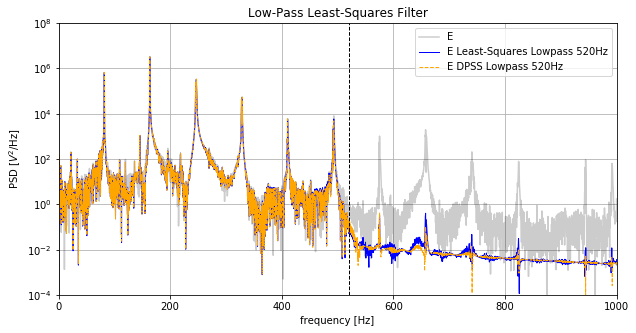

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.semilogy(f_E, Pxx_den_E_d, label='E', c='k', alpha=0.2)
ax.semilogy(f_E_lsq3, Pxx_den_E_lsq3, label='E Least-Squares Lowpass 520Hz', lw=1, c='Blue')
ax.semilogy(f_E_dpss3, Pxx_den_E_dpss3, label='E DPSS Lowpass 520Hz', lw=1, c='Orange', ls='--')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [$V^2$/Hz]')
ax.set_xlim(0,1000)
ax.set_ylim(10**-4, 10**8)
ax.legend()
ax.grid()
ax.set_title('Low-Pass Least-Squares Filter')

ax.axvline(520, ls='--', color='k', lw=1)

plt.savefig('test_plot.png', dpi=300)
plt.show()

Note that the **side lobe** behaviour is better but the freqnuecy directly after the cutoff isnt filtered as well (**broadband**).